In [11]:
import warnings
warnings.filterwarnings("ignore")

In [17]:
from keras.optimizers import SGD
from keras.layers import Input, merge, ZeroPadding2D,concatenate, add
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
import keras.backend as K
import numpy as np

from sklearn.metrics import log_loss

from custom_layers.scale_layer import Scale

from load_cifar10 import load_cifar10_data

In [43]:
def dense_block(x, stage, nb_layers, nb_filter, growth_rate, dropout_rate=None, weight_decay=1e-4, grow_nb_filters=True):
    ''' Build a dense_block where the output of each conv_block is fed to subsequent ones
        # Arguments
            x: input tensor
            stage: index for dense block
            nb_layers: the number of layers of conv_block to append to the model.
            nb_filter: number of filters
            growth_rate: growth rate
            dropout_rate: dropout rate
            weight_decay: weight decay factor
            grow_nb_filters: flag to decide to allow number of filters to grow
    '''

    eps = 1.1e-5
    concat_feat = x

    for i in range(nb_layers):
        branch = i+1
        x = conv_block(concat_feat, stage, branch, growth_rate, dropout_rate, weight_decay)
        concat_feat = concatenate([concat_feat, x], axis=concat_axis, name='concat_'+str(stage)+'_'+str(branch))

        if grow_nb_filters:
            nb_filter += growth_rate

    return concat_feat, nb_filter

In [44]:
def transition_block(x, stage, nb_filter, compression=1.0, dropout_rate=None, weight_decay=1E-4):
    ''' Apply BatchNorm, 1x1 Convolution, averagePooling, optional compression, dropout 
        # Arguments
            x: input tensor
            stage: index for dense block
            nb_filter: number of filters
            compression: calculated as 1 - reduction. Reduces the number of feature maps in the transition block.
            dropout_rate: dropout rate
            weight_decay: weight decay factor
    '''

    eps = 1.1e-5
    conv_name_base = 'conv' + str(stage) + '_blk'
    relu_name_base = 'relu' + str(stage) + '_blk'
    pool_name_base = 'pool' + str(stage) 

    x = BatchNormalization(epsilon=eps, axis=concat_axis, name=conv_name_base+'_bn')(x)
    x = Scale(axis=concat_axis, name=conv_name_base+'_scale')(x)
    x = Activation('relu', name=relu_name_base)(x)
    x = Convolution2D(int(nb_filter * compression), 1, 1, name=conv_name_base, bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    x = AveragePooling2D((2, 2), strides=(2, 2), name=pool_name_base)(x)

    return x


In [45]:
def conv_block(x, stage, branch, nb_filter, dropout_rate=None, weight_decay=1e-4):
    '''Apply BatchNorm, Relu, bottleneck 1x1 Conv2D, 3x3 Conv2D, and option dropout
        # Arguments
            x: input tensor 
            stage: index for dense block
            branch: layer index within each dense block
            nb_filter: number of filters
            dropout_rate: dropout rate
            weight_decay: weight decay factor
    '''
    eps = 1.1e-5
    conv_name_base = 'conv' + str(stage) + '_' + str(branch)
    relu_name_base = 'relu' + str(stage) + '_' + str(branch)

    # 1x1 Convolution (Bottleneck layer)
    inter_channel = nb_filter * 4  
    x = BatchNormalization(epsilon=eps, axis=concat_axis, name=conv_name_base+'_x1_bn')(x)
    x = Scale(axis=concat_axis, name=conv_name_base+'_x1_scale')(x)
    x = Activation('relu', name=relu_name_base+'_x1')(x)
    x = Convolution2D(inter_channel, 1, 1, name=conv_name_base+'_x1', bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    # 3x3 Convolution
    x = BatchNormalization(epsilon=eps, axis=concat_axis, name=conv_name_base+'_x2_bn')(x)
    x = Scale(axis=concat_axis, name=conv_name_base+'_x2_scale')(x)
    x = Activation('relu', name=relu_name_base+'_x2')(x)
    x = ZeroPadding2D((1, 1), name=conv_name_base+'_x2_zeropadding')(x)
    x = Convolution2D(nb_filter, 3, 3, name=conv_name_base+'_x2', bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    return x


In [46]:
def densenet121_model(img_rows, img_cols, color_type=1, nb_dense_block=4, growth_rate=32, nb_filter=64, reduction=0.5, dropout_rate=0.0, weight_decay=1e-4, num_classes=None):
    '''
    DenseNet 121 Model for Keras

    Model Schema is based on 
    https://github.com/flyyufelix/DenseNet-Keras

    ImageNet Pretrained Weights 
    Theano: https://drive.google.com/open?id=0Byy2AcGyEVxfMlRYb3YzV210VzQ
    TensorFlow: https://drive.google.com/open?id=0Byy2AcGyEVxfSTA4SHJVOHNuTXc

    # Arguments
        nb_dense_block: number of dense blocks to add to end
        growth_rate: number of filters to add per dense block
        nb_filter: initial number of filters
        reduction: reduction factor of transition blocks.
        dropout_rate: dropout rate
        weight_decay: weight decay factor
        classes: optional number of classes to classify images
        weights_path: path to pre-trained weights
    # Returns
        A Keras model instance.
    '''
    eps = 1.1e-5

    # compute compression factor
    compression = 1.0 - reduction

    # Handle Dimension Ordering for different backends
    global concat_axis
    if K.image_dim_ordering() == 'tf':
      concat_axis = 3
      img_input = Input(shape=(img_rows, img_cols, color_type), name='data')
    else:
      concat_axis = 1
      img_input = Input(shape=(color_type, img_rows, img_cols), name='data')

    # From architecture for ImageNet (Table 1 in the paper)
    nb_filter = 64
    nb_layers = [6,12,24,16] # For DenseNet-121

    # Initial convolution
    x = ZeroPadding2D((3, 3), name='conv1_zeropadding')(img_input)
    x = Convolution2D(nb_filter, 7, 7, subsample=(2, 2), name='conv1', bias=False)(x)
    x = BatchNormalization(epsilon=eps, axis=concat_axis, name='conv1_bn')(x)
    x = Scale(axis=concat_axis, name='conv1_scale')(x)
    x = Activation('relu', name='relu1')(x)
    x = ZeroPadding2D((1, 1), name='pool1_zeropadding')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), name='pool1')(x)

    # Add dense blocks
    for block_idx in range(nb_dense_block - 1):
        stage = block_idx+2
        x, nb_filter = dense_block(x, stage, nb_layers[block_idx], nb_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)

        # Add transition_block
        x = transition_block(x, stage, nb_filter, compression=compression, dropout_rate=dropout_rate, weight_decay=weight_decay)
        nb_filter = int(nb_filter * compression)

    final_stage = stage + 1
    x, nb_filter = dense_block(x, final_stage, nb_layers[-1], nb_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)

    x = BatchNormalization(epsilon=eps, axis=concat_axis, name='conv'+str(final_stage)+'_blk_bn')(x)
    x = Scale(axis=concat_axis, name='conv'+str(final_stage)+'_blk_scale')(x)
    x = Activation('relu', name='relu'+str(final_stage)+'_blk')(x)

    x_fc = GlobalAveragePooling2D(name='pool'+str(final_stage))(x)
    x_fc = Dense(num_classes, name='fc6')(x_fc)
    x_fc = Activation('softmax', name='prob')(x_fc)

    model = Model(img_input, x_fc, name='densenet')

    #if K.image_dim_ordering() == 'th':
    #  # Use pre-trained weights for Theano backend
    #  weights_path = 'imagenet_models/densenet121_weights_th.h5'
    #else:
    #  # Use pre-trained weights for Tensorflow backend
    #  weights_path = 'imagenet_models/densenet121_weights_tf.h5'

    #model.load_weights(weights_path, by_name=True)

    # Truncate and replace softmax layer for transfer learning
    # Cannot use model.layers.pop() since model is not of Sequential() type
    # The method below works since pre-trained weights are stored in layers but not in the model
    x_newfc = GlobalAveragePooling2D(name='pool'+str(final_stage))(x)
    x_newfc = Dense(num_classes, name='fc6')(x_newfc)
    x_newfc = Activation('softmax', name='prob')(x_newfc)

    model = Model(img_input, x_newfc)

    # Learning rate is changed to 0.001
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [15]:
def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r, g, b = np.asarray(.3, dtype=dtype), np.asarray(.59, dtype=dtype), np.asarray(.11, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    # add channel dimension
    rst = np.expand_dims(rst, axis=3)
    return rst

In [41]:
from keras.datasets import cifar10
from keras.utils import np_utils

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# convert class vectors to binary vectors
Y_train = np_utils.to_categorical(y_train)
Y_test = np_utils.to_categorical(y_test)

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)

X_train shape: (50000, 32, 32, 3)
Y_train shape: (50000, 10)
X_test shape: (10000, 32, 32, 3)
Y_test shape: (10000, 10)


In [47]:
import _pickle as pickle
from keras.utils import np_utils
import numpy as np

def load_data(file_name):
    file_path = os.path.join(data_path, "cifar-10-batches-py/", file_name)
    
    print('Loading ' + file_name)
    with open(file_path, mode='rb') as file:    
        data = pickle.load(file, encoding='bytes')
    raw_images = data[b'data']
    cls = np.array(data[b'labels'])
    
    images = raw_images.reshape([-1, img_channels, img_size, img_size])    
    # move the channel dimension to the last
    images = np.rollaxis(images, 1, 4)
    
    return images, cls

def load_training_data():    
    # pre-allocate the arrays for the images and class-numbers for efficiency.
    images = np.zeros(shape=[nb_images_train, img_size, img_size, img_channels], 
                      dtype=int)
    cls = np.zeros(shape=[nb_images_train], dtype=int)
    
    begin = 0
    for i in range(nb_files_train):
        images_batch, cls_batch = load_data(file_name="data_batch_" + str(i + 1))
        num_images = len(images_batch)
        end = begin + num_images
        images[begin:end, :] = images_batch
        cls[begin:end] = cls_batch
        begin = end
        
    return images, np_utils.to_categorical(cls, nb_classes)

def load_test_data():
    images, cls = load_data(file_name="test_batch")
    
    return images, np_utils.to_categorical(cls, nb_classes)

def load_cifar():
    X_train, Y_train = load_training_data()
    X_test, Y_test = load_test_data()
    
    return X_train, Y_train, X_test, Y_test

In [49]:
#X_train, Y_train, X_test, Y_test = load_cifar()

print('\nX_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)


X_train shape: (50000, 32, 32, 3)
Y_train shape: (50000, 10)
X_test shape: (10000, 32, 32, 3)
Y_test shape: (10000, 10)


In [50]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

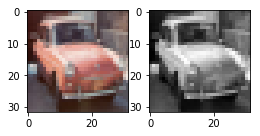

In [51]:
import matplotlib.pyplot as plt
X_train_gray = grayscale(X_train)
X_test_gray = grayscale(X_test)

# now we have only one channel in the images
img_channels = 1

# plot a randomly chosen image
img = 64
plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.imshow(X_train[img], interpolation='none')
plt.subplot(1, 2, 2)
plt.imshow(X_train_gray[img, :, :, 0], cmap=plt.get_cmap('gray'), interpolation='none')
plt.show()

In [52]:
from sklearn.model_selection import train_test_split

X_train_gray, X_val_gray, Y_train, Y_val = train_test_split(X_train_gray, Y_train, test_size=0.2, random_state=0)

print('X_train_gray shape:', X_train_gray.shape)
print('X_val_gray shape:', X_val_gray.shape)

X_train_gray shape: (40000, 32, 32, 1)
X_val_gray shape: (10000, 32, 32, 1)


In [55]:
from keras.callbacks import EarlyStopping

# define constants
batch_size = 128
epoch_max = 100
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0)


In [ ]:
img_rows = 32
img_cols = 32
channel = 1
num_classes = 10

model = densenet121_model(img_rows=img_rows, img_cols=img_cols, color_type=channel, num_classes=num_classes)
hist = model.fit(X_train_gray, Y_train, \
                    batch_size=batch_size, \
                    nb_epoch=epoch_max, \
                    validation_data=(X_val_gray, Y_val), \
                    callbacks=[early_stop], \
                    shuffle=True, verbose=1)

In [ ]:
## Code inspired and followed from 

## http://www.cs.nthu.edu.tw/~shwu/courses/ml/labs/11_NN_Regularization/11_NN_Regularization.html